# 18장 시퀀스 배열로 다루는 순환 신경망(RNN)

[<img src="https://raw.githubusercontent.com/taehojo/taehojo.github.io/master/assets/images/linktocolab.png" align="left"/> ](https://colab.research.google.com/github/taehojo/deeplearning/blob/master/colab/ch18-colab.ipynb)

## 1. LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 데이터를 확인해 보겠습니다.
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [2]:
# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=100) # 총 100개 단어
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리를 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [3]:
# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
450/450 [==============================] - 15s 30ms/step - loss: 2.1664 - accuracy: 0.4733 - val_loss: 2.0122 - val_accuracy: 0.5009
Epoch 2/200
450/450 [==============================] - 13s 30ms/step - loss: 1.8957 - accuracy: 0.5164 - val_loss: 1.7829 - val_accuracy: 0.5361
Epoch 3/200
450/450 [==============================] - 13s 30ms/step - loss: 1.6858 - accuracy: 0.5638 - val_loss: 1.6608 - val_accuracy: 0.5721
Epoch 4/200
450/450 [==============================] - 13s 29ms/step - loss: 1.5461 - accuracy: 0.6015 - val_loss: 1.5171 - val_accuracy: 0.6300
Epoch 5/200
450/450 [==============================] - 14s 30ms/step - loss: 1.3192 - accuracy: 0.6683 - val_loss: 1.3342 - val_accuracy: 0.6687
Epoch 6/200
450/450 [==============================] - 14s 31ms/step - loss: 1.1749 - accuracy: 0.7025 - val_loss: 1.2535 - val_accuracy: 0.6745
Epoch 7/200
450/450 [==============================] - 14s 31ms/step - loss: 1.0395 - accuracy: 0.7409 - val_loss: 1.1817 - val_ac

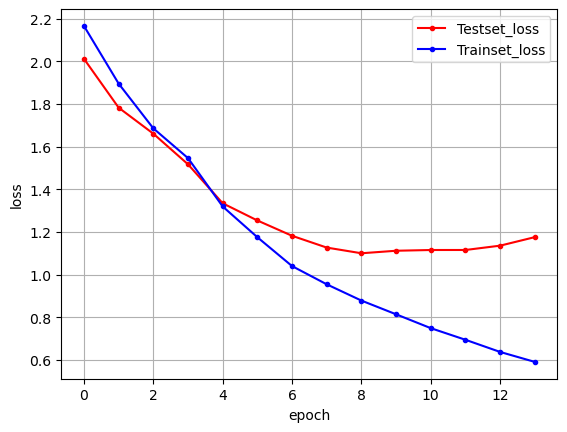

In [4]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

17464789/17464789 [==============================] - 10s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         500000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 55)                26400     
                                                                 
 dense (Dense)               (None, 1)                 5

In [2]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
469/469 [==============================] - 34s 68ms/step - loss: 0.4111 - accuracy: 0.8063 - val_loss: 0.2991 - val_accuracy: 0.8770
Epoch 2/100
469/469 [==============================] - 31s 66ms/step - loss: 0.2345 - accuracy: 0.9091 - val_loss: 0.2574 - val_accuracy: 0.8938
Epoch 3/100
469/469 [==============================] - 31s 66ms/step - loss: 0.1811 - accuracy: 0.9344 - val_loss: 0.2858 - val_accuracy: 0.8835
Epoch 4/100
469/469 [==============================] - 32s 68ms/step - loss: 0.1498 - accuracy: 0.9467 - val_loss: 0.3168 - val_accuracy: 0.8846
Epoch 5/100
782/782 [==============================] - 13s 16ms/step - loss: 0.3363 - accuracy: 0.8724

 Test Accuracy: 0.8724


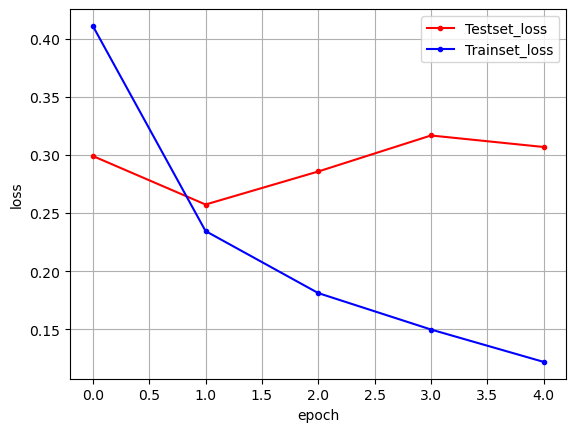

In [3]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 3. 어텐션을 사용한 신경망

In [4]:
!pip install attention

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from attention import Attention

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Attention()) # 어텐션 스코어와 어텐션 가중치를 계산
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100,  validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
625/625 [==============================] - 355s 566ms/step - loss: 0.3693 - accuracy: 0.8309 - val_loss: 0.2727 - val_accuracy: 0.8870
Epoch 2/100
625/625 [==============================] - 344s 551ms/step - loss: 0.2187 - accuracy: 0.9143 - val_loss: 0.2806 - val_accuracy: 0.8919
Epoch 3/100
625/625 [==============================] - 345s 552ms/step - loss: 0.1601 - accuracy: 0.9370 - val_loss: 0.2912 - val_accuracy: 0.8837
Epoch 4/100
782/782 [==============================] - 94s 120ms/step - loss: 0.3311 - accuracy: 0.8808

 Test Accuracy: 0.8808


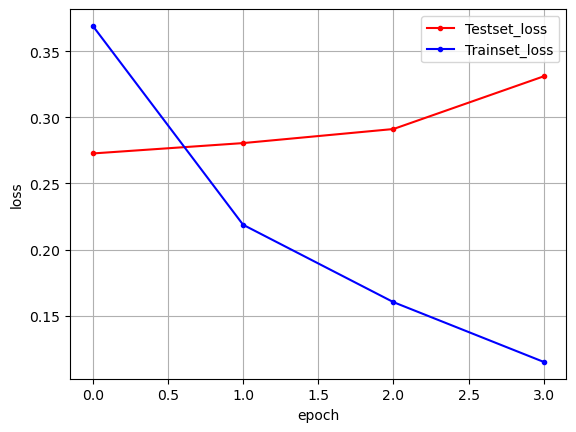

In [6]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()